# Gaia DR3 detectability of unresolved binary systems

updated 23 Apr. 2024

In this notebook, we discuss how to estimate the detectability of unresolved binary systems based on RUWE. 

We also present a forward model to simulate a RUWE value for well-behaved single sources or binary systems, based on the astrimetric goodness-of-fit. We present a sky-varying map of maximum RUWE values compatible with single sources, where sources with larger RUWE can be considered potential binary systems.

This work is currently based on precomputed maps at a resolution of HEALPix level 5. However, the procedure described here, further developed in [Castro-Ginard et al. (2024)](https://arxiv.org/abs/2404.14127), is applicable to any resolution (Gaia scanning law details from GOST are required).

### Sky-varying RUWE threshold

One of the main results in [Castro-Ginard et al. (2024)](https://arxiv.org/abs/2404.14127) is Fig. 3, which shows a sky-varying RUWE thresdhold above which soucers show potential signs of binarity. 

To reproduce the plot, and access these RUWE values, we need to import the relevant module from the GaiaUnlimited package and create the selection function object. 

In [1]:
from gaiaunlimited.selectionfunctions import binaries

binariesSF = binaries.BinarySystemsSelectionFunction()

This object provides a pre-computed table at HEALPix level 5, which includes for each pixel the RUWE thresholds together with the Gaia scanning law details needed to compute them and the probability to select sources with a RUWE higher than the threshold (estimated as in [Castro-Ginard et al., 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...677A..37C/abstract)).

These values are accessible through their sky coordinates, using an astropy SkyCoord object. We generate the coordinates of the centres of each HEALPix at level 5 to generate an all-sky map.

In [5]:
from gaiaunlimited import fetch_utils,utils

coords_of_centres = utils.get_healpix_centers(5)
coords_of_centres

<SkyCoord (ICRS): (ra, dec) in deg
    [( 45.,  88.53802884), (135.,  88.53802884), (225.,  88.53802884), ...,
     (135., -88.53802884), (225., -88.53802884), (315., -88.53802884)]>

Then, we query the values for the RUWE threshold with:

In [6]:
ruwe_threshold = binariesSF.query_RUWE(coords_of_centres,crowding = True)

print("RUWE threshold per pixel:")
print(ruwe_threshold)

RUWE threshold per pixel:
[1.23154472 1.22303619 1.23142854 ... 1.21690457 1.22044218 1.22285574]


The argument "crowding = True" gives us the contribution to a increased RUWE from sources other than binarity, gauged directly from Gaia data. Setting "crowding = False" will provide a RUWE threshold where values above are only increased by binarity. The default and recommended setting for "crowding" is True.

To show a sky map of these values we use the healpy python package.

<Figure size 432x288 with 0 Axes>

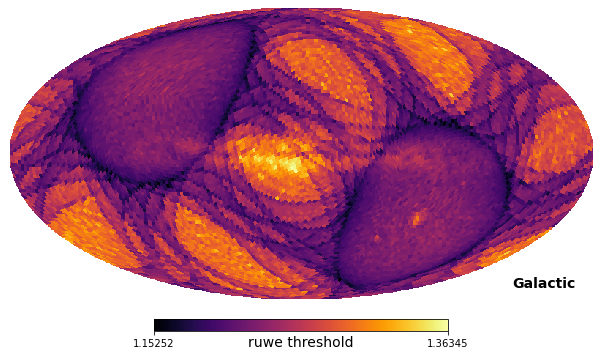

In [14]:
import healpy as hp
import matplotlib.pyplot as plt

plt.figure()
hp.mollview(ruwe_threshold,coord = ['C','G'],cmap = 'inferno',title = None,unit = 'ruwe threshold')
plt.show()

The Gaia scanning law details to estimate the above values are also accessible through the selection function object we created. This will provide the observation times, scanning angles or the along-scan parallax factors for each CCD observation of a certain pixel (usually 9 CCD observations per source transit). The number of observations can be derived from the previous. These data are collected through the Gaia Observation Forecast Tool ([GOST](https://gaia.esac.esa.int/gost/)).

Number of CCD observations per pixel:
[422 475 429 ... 477 453 437]


<Figure size 432x288 with 0 Axes>

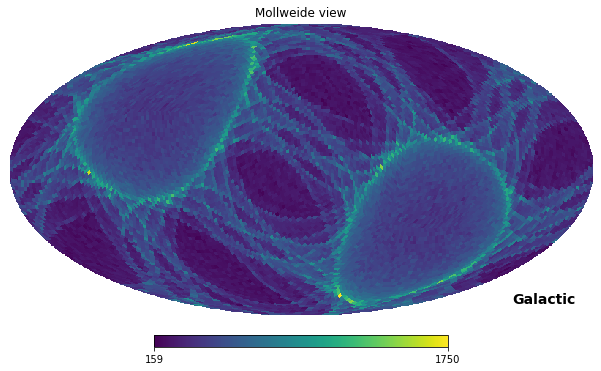

In [17]:
import numpy as np

observation_times, scanning_angles, AL_parallax_factors = binariesSF.query_ScanningLaw(coords_of_centres)

print("Number of CCD observations per pixel:")
n_observations = np.hstack([len(observation_times[i]) for i in range(hp.order2npix(5))])
print(n_observations)

plt.figure()
hp.mollview(n_observations,coord = ['C','G'])
plt.show()

### Selection function of potential binary systems based on RUWE

Based on this sky-varyin RUWE threshold we can estimate the probability to select sources with RUWE higher than the threshold, which can be seen as potential binary systems (note that there are other contributions that will lead to an increased RUWE which are not taken into account).

These probabilities are computed using the [subsample selection function](https://github.com/gaia-unlimited/gaiaunlimited/blob/main/docs/notebooks/constructing_SelectionFunctions.ipynb), and are dependend only on the sky coordinates. These probabilities are a multiplicative factor to the [Gaia catalogue selection](https://github.com/gaia-unlimited/gaiaunlimited/blob/main/docs/notebooks/dr3-empirical-completeness.ipynb) function, described in [Cantat-Gaudin et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023A%26A...669A..55C/abstract), and which depends on the sky coordinates and magnitude.

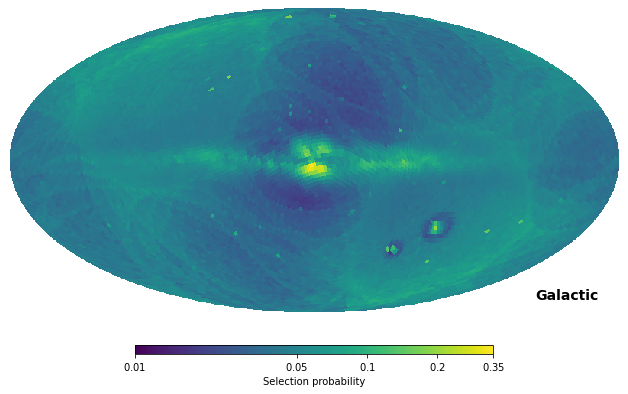

<Figure size 432x288 with 0 Axes>

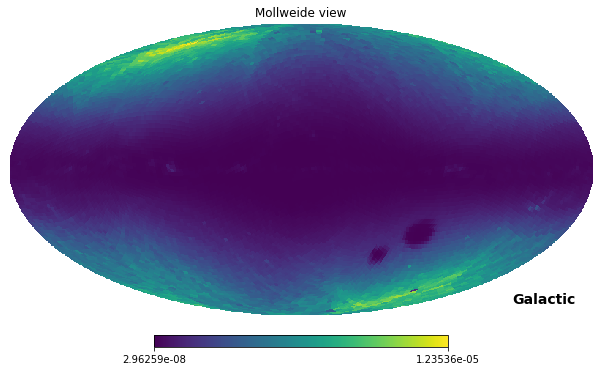

In [31]:
probability,variance = binariesSF.query(coords_of_centres,return_variance = True)

fig = plt.figure(figsize = (11,11))
hp.mollview(probability,title = None,coord = ['C','G'],badcolor = 'white',norm = 'log',min = 0.01,max = 0.35,cbar = None,hold = True)
im = fig.axes[0].get_images()[0]
cb = plt.colorbar(im,ax = fig.axes,aspect = 40,location = 'bottom',fraction = 0.015,pad = 0.05)
cb.set_ticks([0.01,0.05,0.1,0.2,0.35])
cb.set_ticklabels([r'$0.01$',r'$0.05$',r'$0.1$',r'$0.2$',r'$0.35$'])
cb.set_label(r'Selection probability')
plt.show()

plt.figure()
hp.mollview(variance,coord = ['C','G'])
plt.show()

### Forward model to estimate the RUWE for a simulated source

This functionality shows how to estimate a RUWE value for a simulated source observed by Gaia, being the source either a single source or a binary.

In [1]:
from gaiaunlimited.utils import SimulateGaiaSource

We simulate both a single source and a binary at a given location in the sky, providing $\alpha^*$ and $\delta$. 

The single source will be characterised by not having a period, eccentricity and initial phase ($= 0$).

The period, eccentricity and initial phase for the simulated binary system is drawn from the distribution described in Table 1 in Castro-Ginard et al. (2024).

In [7]:
ra = 240.
dec = -40.

single_source = SimulateGaiaSource(ra, dec, period = 0, eccentricity = 0, initial_phase = 0)

period_binary = 10**np.random.uniform(low = -2.56,high = 2)
eccentricity_binary = np.random.uniform(low = 0,high = 1)
initial_phase_binary = np.random.uniform(low = 0,high = 2*np.pi)

binary_source = SimulateGaiaSource(ra, dec, period = period_binary, \
                                            eccentricity = eccentricity_binary, \
                                            initial_phase = initial_phase_binary)

We need the G magnitude of the source to compure its along-scan astrometric error and the parallax of the source.

Additionally, we need the rest of the parameters that will determine the detectability of the source as an unresolved binary system (for the case of the simulated single source, these parameters are $= 0$). The simulated parameters for the binary system are also taken from Table 1 in Castro-Ginard et al. (2024).

In [9]:
Gmag = 12.
parallax = 1.2

single_al_position, single_al_error = single_source.observe(Gmag, parallax,\
                                       0,\
                                       0, 0,\
                                       0, 0, 0,)

mass_ratio_binary = np.random.uniform(low = 0,high = 1)
luminosity_ratio_binary = mass_ratio_binary ** 3.5
semimajor_axis_binary = ((1 + 1 * mass_ratio_binary) * period_binary**2)**(1/3)
phi_binary = np.random.uniform(low = 0,high = 2*np.pi)
theta_binary = np.arccos(np.random.uniform(low = -1,high = 1))
omega_binary = np.random.uniform(low = 0,high = 2*np.pi)

binary_al_position, binary_al_error = binary_source.observe(Gmag, parallax,\
                                       semimajor_axis_binary,\
                                       mass_ratio_binary, luminosity_ratio_binary,\
                                       phi_binary, theta_binary, omega_binary,)

We now estimate the ruwes using the following function: 

In [11]:
ruwe_single = single_source.unit_weight_error(single_al_position, single_al_error)
ruwe_binary = binary_source.unit_weight_error(binary_al_position, binary_al_error)

print('ruwe for single source: {}'.format(ruwe_single))
print('ruwe for binary source: {}'.format(ruwe_binary))

ruwe for single source: [0.98569552]
ruwe for binary source: [0.98859412]


The signs of binarity on RUWE may be negligible depending on the properties of the binary system. So, the RUWE values for both the single and binary source may be very similar. 

To better see the impact of an unseen companion into the RUWE distribution, we can simulate a full population of both single and binary sources and see how the distribution on RUWE differs.

Note: the parameters of the simulated population are those described in Sect. 3 of Castro-Ginard et al. (2024), and are not provided within the notebook. In any case, the purpose of the following cell is to show how to estimate RUWE for a large population of sources, using parallel computations through numpy arrays as inputs of the ".observe" functionality. Parallel computations are not yet implemented for sky position, period, eccentricty and initial phase (inputs of the "SimulateGaiaSource" class.

In [24]:
# The inputs of .observe are numpy arrays

single_al_position, single_al_error = single_source.observe(Gmag, parallax,\
                                       np.zeros(len(Gmag)),\
                                       np.zeros(len(Gmag)), np.zeros(len(Gmag)),\
                                       np.zeros(len(Gmag)), np.zeros(len(Gmag)), np.zeros(len(Gmag)),)

binary_al_position, binary_al_error = binary_source.observe(Gmag, parallax,\
                                       semimajor_axis_binary,\
                                       mass_ratio_binary, luminosity_ratio_binary,\
                                       phi_binary, theta_binary, omega_binary,)

In [25]:
ruwe_single = single_source.unit_weight_error(single_al_position, single_al_error)
ruwe_binary = binary_source.unit_weight_error(binary_al_position, binary_al_error)

print('ruwe for single source: {}'.format(ruwe_single))
print('ruwe for binary source: {}'.format(ruwe_binary))

ruwe for single source: [0.99646566 0.95951754 1.00014012 ... 1.02464899 1.01424336 0.96124657]
ruwe for binary source: [1.03793864 0.97445303 1.08296424 ... 0.94831897 0.95937766 1.01985592]


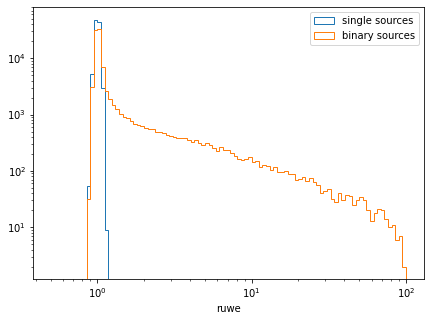

In [38]:
plt.figure(figsize = (7,5))
plt.hist(ruwe_single,bins = np.logspace(np.log10(0.5),np.log10(100),100),histtype = 'step',label = 'single sources')
plt.hist(ruwe_binary,bins = np.logspace(np.log10(0.5),np.log10(100),100),histtype = 'step',label = 'binary sources')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ruwe')
plt.legend()
plt.show()